In [40]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from IPython.display import Image

# Predicting Movie Genres

By Kyle Vigil

## Question

My overall goal is to be able to predict movie genre based on a table full of movie metadata.

## Data Set

<img src="groupLens.gif">

I am using a data set from GroupLens that is based off of data from Rotten Tomatoes that has over 10,000 movies.

## Cleaning The Data

This part isn't the most interesting of sections except for a few problem areas.

### Genre

In [41]:
genres = pd.read_csv('/data/kylevigil/movie_genres.dat', delimiter = '\t')
genres.genre = genres.genre.astype('category')

The genre proved to be tough due to each movie having multiple listed genres. The way I handled it was to boil the genres down to five categories:
* Drama
* Comedy
* Romance
* Action
* Horror

I assigned these categories by choosing the least popular genre in its list of genres for each movie.

In [42]:
genres.genre.value_counts()[['Drama','Comedy','Romance','Action','Horror']]

Drama      5076
Comedy     3566
Romance    1644
Action     1445
Horror      978
dtype: int64

For example, a movie with genres: ['Drama', 'Comedy', 'Horror'] would recieve a genre of 'Horror' because it is the least popular in the list and is one of the five categories. I do this because the least represented genres in the data set as a whole is the best way to classify each movie, its what makes it unique. 

### Sentiment

In [4]:
from textblob import TextBlob

One interesting way to get data was through the use of sentiment. I applied this to both the movie's title and user submitted tags for each movie.

For example, given these movie titles and tags (which are actually in the dataset) I found the sentiment of each.

In [43]:
movies = pd.DataFrame(['Happy Gilmore', 'Evil Angels',"It's A Wonderful Life", 'Prom Night IV: Deliver Us from Evil'],
                      columns=['Movie'])
movies['titleSentiment'] = [TextBlob(i).sentiment.polarity for i in movies.Movie]
movies

,Movie,titleSentiment
0,Happy Gilmore,0.8
1,Evil Angels,-1.0
2,It's A Wonderful Life,1.0
3,Prom Night IV: Deliver Us from Evil,-1.0


In [44]:
tags = pd.DataFrame(['drama bittersweet happy feelgood toplist08','beautiful birds surprise ending parrots bird',
                    'gory to see awful hard to watch bloody criterion','bleak grim matteroffact downbeat'], columns=["allTags"])
tags['tagSentiment'] = [TextBlob(i).sentiment.polarity for i in tags.allTags]
tags

,allTags,tagSentiment
0,drama bittersweet happy feelgood toplist08,0.800000
1,beautiful birds surprise ending parrots bird,0.850000
2,gory to see awful hard to watch bloody criterion,-0.647917
3,bleak grim matteroffact downbeat,-1.000000


### Poster Color

An interesting piece of data that I gathered was color of movie posters. I hypothesized that this would heavily corelate to the genre of the movie.

In [45]:
from PIL import Image
from io import BytesIO
import requests
from sklearn.cluster import KMeans
import math

In [47]:
def get_most_popular_color(html):
    """
    return rgb value of the most popular color in an html image
    
     Parameters
    ----------
    html : string
        the html address of the image of the movie poster
    """
    response = requests.get(html)
    try:
        img = np.array(Image.open(BytesIO(response.content)))
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        clt = KMeans(n_clusters = 3)
        clt.fit(img)
        colorMax = tuple(clt.cluster_centers_[
                np.argmax(np.histogram(clt.labels_, bins = np.arange(0, len(np.unique(clt.labels_)) + 1))[0])])
        return colorMax
    except:
        return 'None'

In [48]:
def graph_color(c):
    """ graphs the most popular color from an image as a square """
    (r,g,b) = c
    c = (r/255, g/255, b/255)
    plt.plot([0,0], lw=400, color = c)
    plt.axis('off')
    plt.show()

We can look at this in action with a generic photo:

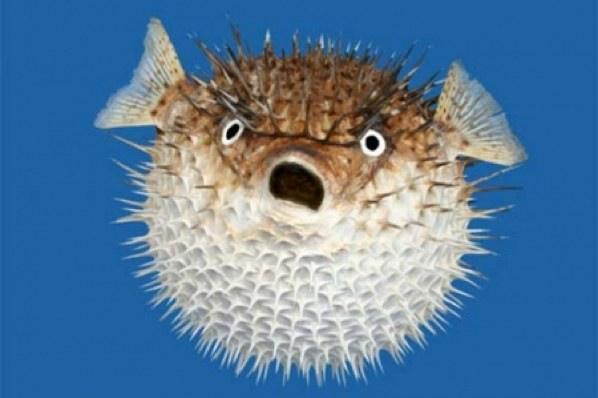

In [49]:
url = "http://easyscienceforkids.com/wp-content/uploads/2013/06/puffer-fish.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

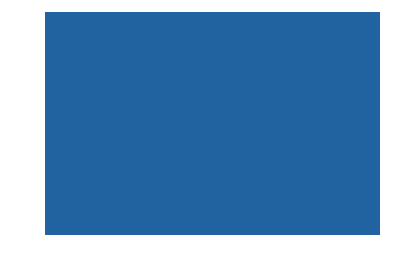

In [50]:
color1 = get_most_popular_color(url)
graph_color(color1)

This most importantly applies well to movie posters:

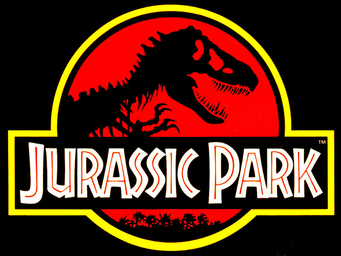

In [51]:
url = "https://upload.wikimedia.org/wikipedia/en/9/96/Jurassic_Park_logo.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content))
img

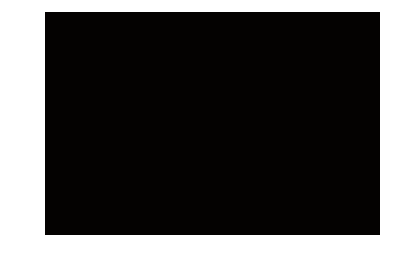

In [52]:
color2 = get_most_popular_color(url)
graph_color(color2)

In order to use this data most effectively I need to make this data categorical. I did this by finding the nearest color in a dictionary of colors to the most popular color of each poster. 

In [14]:
rgb_code_dictionary = { (255, 255, 0): 'yellow',
(255, 0, 255): 'magenta',
(0, 255, 255): 'cyan',
(255, 0, 0): 'red',
(255, 125, 125): 'light red',
(0, 255, 0): 'green',
(122,225,122): 'light green',
(0, 0, 255): 'blue',
(100, 100, 255): 'light blue',
(255, 255, 255): 'white',
(0, 0, 0): 'black',
(210, 180, 140): 'tan',
(125, 0, 0): 'dark red',
(0, 125, 0): 'dark green',
(0, 0, 125): 'dark blue'}

In [53]:
def distance(c1, c2):
    """ returns the squared distance between two colors
    
    Params
    ---------
    c1 : tuple
        Color number 1
    c2 : tuple
        Color number 2
    """
    (r1,g1,b1) = c1
    (r2,g2,b2) = c2
    return math.sqrt((r1 - r2)**2 + (g1 - g2) ** 2 + (b1 - b2) **2)

In [54]:
def return_text_color(point):
    """ return the color name of the closest color in the dictionary
    
    Params
    ---------
    point : tuple
        Color to define
    """
    colors = list(rgb_code_dictionary.keys())
    closest_colors = sorted(colors, key=lambda color: distance(color, point))
    closest_color = closest_colors[0]
    return rgb_code_dictionary[closest_color]

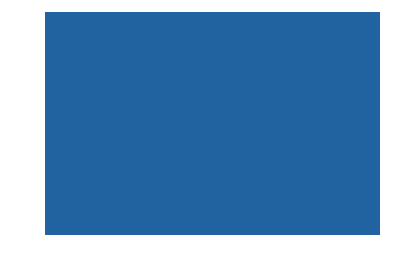

'dark blue'

In [55]:
graph_color(color1)
return_text_color(color1)

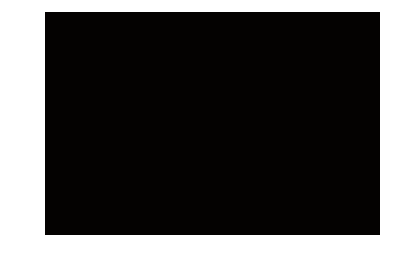

'black'

In [56]:
graph_color(color2)
return_text_color(color2)

### Final Product

In [57]:
moviesData = pd.read_pickle('/data/kylevigil/moviesData.pkl')
moviesData.head()

,title,year,rtAudienceNumRatings,rtAudienceScore,titleSentiment,realGenre,genreNum,directorName,directorNum,posterColor,color,colorNum,actorName,actorNum,tagSentiment,countryNum
1,Toy story,1995,102338,81,0.0,Comedy,1,John Lasseter,2027,dark red,"(104.392166836, 54.7272562127, 43.522889115)",5,Tom Hanks,7241,0.356944,66
3,Grumpy Old Men,1993,10489,66,0.1,Romance,5,Donald Petrie,1038,white,"(240.257754103, 245.865108686, 244.831228342)",11,Jack Lemmon,3122,0.100000,66
5,Father of the Bride Part II,1995,13761,64,0.0,Comedy,1,Charles Shyer,609,dark red,"(66.3822844645, 58.6215606039, 44.2912374771)",5,Steve Martin,6881,0.000000,66
6,Heat,1995,42785,92,0.0,Action,0,Michael Mann,2716,light blue,"(148.308032972, 178.875707128, 227.418005495)",6,Al Pacino,120,0.060606,66
7,Sabrina,1954,12812,87,0.0,Romance,5,Billy Wilder,398,black,"(11.6874206517, 10.4756312597, 11.2805579066)",0,Humphrey Bogart,3009,0.000000,66


## Exploring the Data

I will hand select some of the more interesting graphs and data from each of the columns of data

### Number of Ratings

The number of ratings has one of the most noticeable differences between categories. My theory with this category is that people will tend to want to review different genres of movies more or less than other genres. That is mostly confirmed with action having the most reviews, and drama having the least.

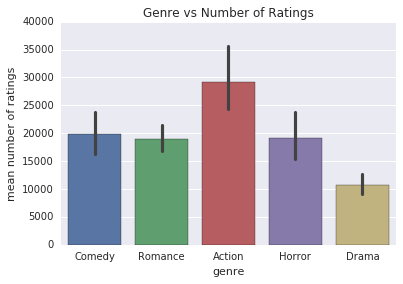

In [58]:
sns.barplot(moviesData.realGenre, moviesData.rtAudienceNumRatings)
plt.title("Genre vs Number of Ratings")
plt.ylabel('mean number of ratings')
plt.xlabel('genre')
plt.show()

### Movie Rating

Like the number of reviews, there is a clear difference between average rating of different genres. Romance and drama tend to get the highest rating while horror gets the lowest. This makes logical sense when thinking about movies, horror movies do tend to be critiqued the most. 

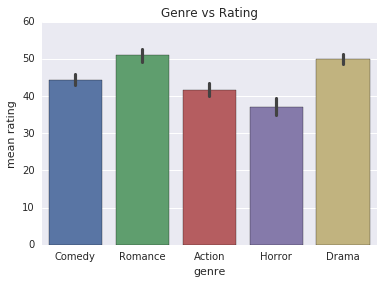

In [59]:
sns.barplot(moviesData.realGenre, moviesData.rtAudienceScore)
plt.title("Genre vs Rating")
plt.ylabel('mean rating')
plt.xlabel('genre')
plt.show()

### Title Sentiment

This section is quite interesting, like I hypothesized, there is a corelation between genre and title sentiment. It makes sense that generally horror movies are going to have negative titles and romance and comedies will have positive ones. The difference between horror and romance is quite satisfying to see.

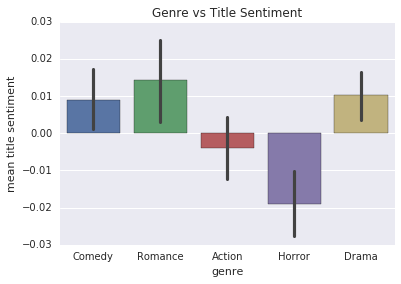

In [60]:
sns.barplot(moviesData.realGenre, moviesData.titleSentiment)
plt.title("Genre vs Title Sentiment")
plt.xlabel('genre')
plt.ylabel('mean title sentiment')
plt.show()

### Actors

This section is hard to visualize due to the sheer amount of actors, so I will select the four actors with the most movies stared in. My goal is to show that actors like to do the same types of movies genre wise.

In [61]:
moviesData.actorName.value_counts()[:4]

Robert De Niro    33
Clint Eastwood    30
Tom Hanks         27
Nicolas Cage      27
dtype: int64

In [62]:
actorsList = list(moviesData.actorName.value_counts()[:4].index)
sample = moviesData[moviesData.actorName.isin(actorsList)]

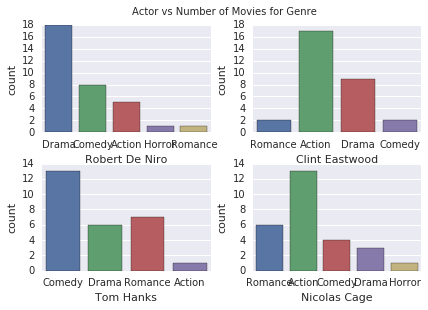

In [63]:
plt.subplots(2,2)
plt.tight_layout()
for i in range(4):
    plt.subplot(2,2,i+1)
    sns.countplot(sample.realGenre[sample.actorName == actorsList[i]])
    plt.xlabel(actorsList[i])
    
plt.suptitle('Actor vs Number of Movies for Genre', y = 1.01)
plt.show()

## Machine Learning

To save time I will only show the best possible model that I found. It turned out to be a Random Forest with all of the features include.

### Best Model

In [64]:
X = moviesData[['year','rtAudienceNumRatings','rtAudienceScore','directorNum','titleSentiment',
                'colorNum','actorNum','tagSentiment','countryNum']]
y = moviesData['genreNum']

In [65]:
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)

In [66]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
model.fit(Xtrain, ytrain)
guess = model.predict(Xtest)

In [67]:
model.score(Xtest, ytest)

0.49542217700915564

As you can see, the best model that I could find could only predict with 50% accuracy. This is probably due to the overlap between movie genres.

In [68]:
from sklearn.metrics import confusion_matrix

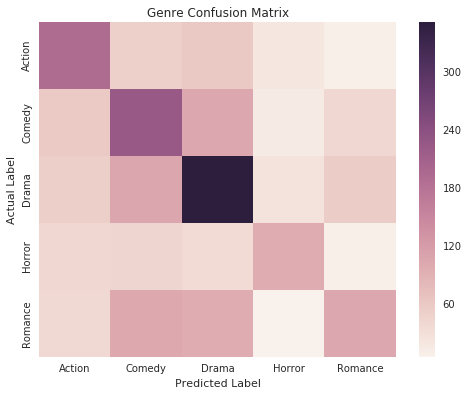

In [69]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(ytest, guess), xticklabels=pd.Categorical(moviesData['realGenre']).categories,
                                            yticklabels=pd.Categorical(moviesData['realGenre']).categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Genre Confusion Matrix')
plt.show()

In [70]:
pd.DataFrame(model.feature_importances_, X.columns.values, columns=['importance']).sort_values('importance', ascending = False)

,importance
directorNum,0.179915
year,0.168166
actorNum,0.126233
rtAudienceNumRatings,0.125544
tagSentiment,0.115841
rtAudienceScore,0.111390
countryNum,0.064131
colorNum,0.064077
titleSentiment,0.044704


### Bonus Model (Horror vs Romance)

I was personally unsatisfied by the low prediction rate of 50% so in an effort to predict something with more accuracy I decided to look at less genres

In [71]:
lessGenres = moviesData[[i == 'Horror' or i == 'Romance' for i in moviesData.realGenre]]
lessGenres[['title','realGenre']].head()

,title,realGenre
3,Grumpy Old Men,Romance
7,Sabrina,Romance
11,The American President,Romance
12,Dracula: Dead and Loving It,Horror
17,Sense and Sensibility,Romance


In [72]:
X = lessGenres[['year','rtAudienceNumRatings','rtAudienceScore','directorNum','colorNum','actorNum','tagSentiment']]
y = lessGenres['genreNum']

In [73]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
bonusModel = RandomForestClassifier()
bonusModel.fit(Xtrain, ytrain)
bonusGuess = bonusModel.predict(Xtest)

As you can see, this model predicted the difference between a horror movie and a romance movie which are two of the most polarized movie genres with pretty decent accuracy.

In [74]:
bonusModel.score(Xtest, ytest)

0.83963963963963961

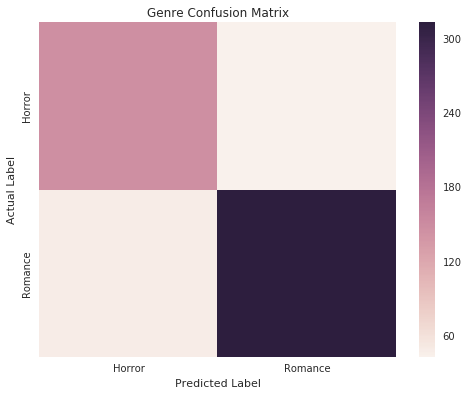

In [37]:
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(ytest, bonusGuess), xticklabels=pd.Categorical(lessGenres['realGenre']).categories,
                                            yticklabels=pd.Categorical(lessGenres['realGenre']).categories)
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Genre Confusion Matrix')
plt.show()

Satisfyingly enough, the color of the movie poster turned out to be quite important on the features list which validates the effort I put into gathering that data.

In [38]:
pd.DataFrame(bonusModel.feature_importances_, X.columns.values, columns=['importance']).sort_values('importance', ascending = False)

,importance
tagSentiment,0.179604
directorNum,0.162188
year,0.162180
colorNum,0.139158
rtAudienceScore,0.124840
actorNum,0.118693
rtAudienceNumRatings,0.113337


## Conclusion

Overall, the model fit wasn't as good as I hoped but it wasn't horrible at the same time. Some of the movies are very hard to tell the genre even as a human, given the same details. For example the movie: The Last Wave, released in 1977, starring Richard Chamberlain, directed by Peter Weir, with an rating of 80 from 3,349 users. Here is the poster:

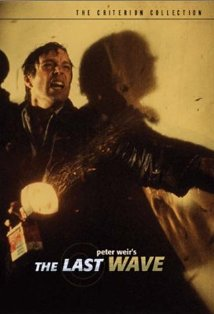

In [39]:
Image.open(BytesIO(requests.get
    ("http://ia.media-imdb.com/images/M/MV5BMTMxNDM0ODk3OF5BMl5BanBnXkFtZTYwODYzMzU5._V1._SY314_CR4,0,214,314_.jpg").content))

Can you guess the genre?

You might have been able to guess drama but you probably weren't 100% on your answer